In [1]:
import torch, time, pickle, os, sys, argparse
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os.path as osp

def convert(d,p):
    dfin=[]
    if len(p)!=len(np.unique(p)):
        print('Wrong order of prog/desc')
    else:
        no=d[0]
        for desc in d:
            if desc==no:
                dfin.append(0)
            else:
                dfin.append(p.index(desc)+1)
    return dfin, np.arange(1, 1+len(p))

def create_graphs(tcols=[0,2,4,5,6,7,8,10,28], target=8, lim=10.5, save=True, case='test', transform='quantile', maxs=[1,1,1]):
    dat=[]
    tcols=np.array(tcols)
    raw_path='~/../../../tigress/mcranmer/merger_trees/isotrees/'
    target_path='~/../../../tigress/mcranmer/merger_trees/samout/'
    transform_path=f"../../../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_allfeat.pkl"
    scaler=pickle.load(open(transform_path, 'rb'))
    not_include=np.array([0,1,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,\
        0,0,0,0,0,0,0,0,0,0,0]) 
    is_cat=[0,1,0,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,\
        0,0,0,0,0,0,0,0,0,0,0]
    is_cat=np.array([bool(i) for i in is_cat])
    icols=np.array([1,3])
    load_cols=np.sort(np.concatenate([tcols,icols]))
    not_include=not_include[load_cols]
    
    for i in range(0, maxs[0]):
        for j in range(0,maxs[1]):
            for k in range(0, maxs[2]):
                start=time.time()
                print(f'Loading isotree {i}_{j}_{k}')
                pd1=pd.read_table(raw_path+f'isotree_{i}_{j}_{k}.dat', skiprows=0, delimiter='\s+', usecols=load_cols)
                print(f'isotree {i}_{j}_{k} loaded, restructuring')
                
                raw=pd1.drop(axis=0, index=np.arange(50)).reset_index()
                del pd1
                
                trees=raw[raw.isna()['desc_id(3)']] 
                halos=raw[~raw.isna()['desc_id(3)']]
                del raw
                
                ##########################################
                ### End loading, begin dtype changing  ###
                ##########################################
                
                mask=halos.dtypes.values[1:]=='O'

                f,it="float64", "int64"
                map1=[]
                map2=[]
                q=0
                for l in load_cols:
                    q+=1
                    if l<25:
                        map1.append(l)
                        map2.append(q)
                map1=np.array(map1)
                map2=np.array(map2)

                castto=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f])

                castto=castto[map1]
                dicts = {}
                keys = halos.columns[map2]
                for d, key in enumerate(keys):
                        dicts[key] = castto[d]

                halos=halos.astype(dicts)
                
                ###################################################
                ### end dtype, begin inital hardcoded scaling   ###
                ###################################################
                
                ## initial scaling
                hard=[0,2,15]
                def logit(x):
                    return np.log10((x+0.001)/(1.01-x))
                ##logit transform the hards
                for h in hard:
                    if h in tcols:
                        h1=np.where(load_cols==h)[0][0]+1
                        halos[halos.columns[h1]]=logit(halos[halos.columns[h1]])

                log=[10,38, 39, 40, 41, 42]
                #simple log for the rest
                def logt(x):
                    return np.log10(x+1)
                for l in log:
                    if l in tcols:
                        l1=np.where(load_cols==l)[0][0]+1
                        halos[halos.columns[l1]]=logt(halos[halos.columns[l1]])

                scale_cols=np.array(tcols[~is_cat[tcols]])

                print(f'Splitting to tree and scaling')
                spli=np.split(np.array(halos)[:,1:], np.array(trees.iloc[1:].index)-np.arange(1,len(trees.index)))
                del halos
                splits=[]
                for s in spli:
                    if s[0,np.where(load_cols==10)[0][0]]>lim:
                        splits.append(s)
                splits=np.array(splits, dtype=object)
                split=[]
                for tree in splits:
                    s=tree[np.logical_or(tree[:,3] == -1,tree[:,4]!=1)]
                    for n in scale_cols:
                        n1=np.where(load_cols==n)[0][0]
                        s[:,n1]=scaler[n].transform(s[:,n1].reshape(-1,1)).reshape(np.shape(s[:,n1]))
                    split.append(s)
                split=np.array(split, dtype=object)
                print('Split done')
                print('Loading targets')
                ex=f'{i}_{j}_{k}/galprop_0-99.dat'
                pdc=pd.read_table(target_path+ex, skiprows=0, delimiter=',', nrows=41, header=None)
                newcols=pdc.iloc[:,0]
                pds=pd.read_table(target_path+ex, skiprows=41, delimiter='\s+', header=None)
                pds.columns=np.array(newcols)
                pd0=pds[pds[pds.columns[3]]==0.00] # subhaloes
                pdcen=pd0[(pd0[pds.columns[1]]==pd0[pds.columns[2]])] ##central haloes

                rhalid=np.array(pdcen[pds.columns[2]])
                del pd0
                del pds
                halwgal=[]
                ids=[]
                out=[]
                for idx, tree in enumerate(split): #split up into tree
                    if tree[0,1] in rhalid:
                        if len(tree)>20000:
                            print(len(tree))
                        else:
                            halwgal.append(tree)
                            ids.append(idx)
                            index=np.where(rhalid==tree[0,1])
                            out.append(np.array(pdcen.iloc[index])[0][target]) ## target variable
                del pdcen

                hraw=np.array(splits[ids], dtype=object)
                hals=[]
                pr,de=[],[]
                discards=[]
                print('Making merger tree')
                for n in tqdm(range(len(halwgal))):
                    h=halwgal[n]
                    roots=h[h[:,4]==0]
                    mergers=h[h[:,4]>1]
                    final=h[h[:,3]==-1]
                    pro, des=[],[]
                    discarded=[]
                    for mid in mergers[:,1]:
                        k=1
                        descid=hraw[n][:,3][np.where(mid==hraw[n][:,1])] ##descendant ID of raw where the id of the merger is
                        while descid not in mergers[:,1] and descid!=-1: 
                            k+=1
                            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]
                        pro.append(mid)
                        if descid!=-1:
                            des.append(descid[0])
                        else:
                            des.append(hraw[n][:,3][np.where(mid==hraw[n][:,1])][0])
                        discarded.append(1/k) 

                    for r in roots:
                        descid=hraw[n][:,3][np.where(r[1]==hraw[n][:,1])] 
                        k=1
                        while descid not in mergers[:,1] and descid!=[-1]: ##could add 1/k
                            k+=1
                            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]#consider adding the number of steps it went through
                        pro.append(r[1])
                        if descid!=-1:
                            des.append(descid[0])
                        else:
                            des.append(hraw[n][:,3][np.where(r[1]==hraw[n][:,1])][0])
                        discarded.append(1/k) 

                    discards.append(np.array(discarded))
                    des,pro=convert(des, pro)
                    hal2=np.vstack([final,mergers,roots])
                    # global mass_index
                    if n==0:
                        fcols=[i for i in range(len(hal2[0])) if not_include[i]==0] ##choose non-id cols to carry forward
                        # mask=np.array([bool(i) for i in not_include])
                        # idcols=load_cols[~mask] ##choose non-id cols to carry forward
                        # mass_id=np.where(np.array(idcols)==10)[0][0]
                    hal2=hal2[:,fcols] ##take away id's
                    hals.append(hal2)
                    pr.append([int(p) for p in pro])
                    de.append([int(d) for d in des])
                hals=np.array(hals,dtype=object)
                out=np.log10(out) #homemade scaling
                for n in tqdm(range(len(out))):
                    edge_index = torch.tensor([pr[n],de[n]], dtype=torch.long)
                    x = torch.tensor(hals[n], dtype=torch.float)
                    y=torch.tensor(out[n], dtype=torch.float)
                    edge_attr=torch.tensor(discards[n], dtype=torch.float)
                    graph=Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
                    dat.append(graph)
                stop=time.time()
                print(f'Done with tree. \n Time elapsed {stop-start} s')
    if save:
        print("Saving dataset")
        if not osp.exists(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}'):
            os.mkdir(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}')

        with open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'wb') as handle:
            pickle.dump(dat, handle)
    return dat

In [2]:
dat=[]
tcols=np.array([0,2,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,35]+list(range(37,60)))
tcols=np.array(tcols)
start=time.time()

raw_path=osp.expanduser('~/../../../tigress/cj1223/merger_trees/isotrees/')
target_path=osp.expanduser('~/../../../tigress/cj1223/merger_trees/samout/')
transform_path=osp.expanduser(f"~/../../../scratch/gpfs/cj1223/GraphStorage/transformers/standard_allfeat.pkl")
scaler=pickle.load(open(transform_path, 'rb'))
not_include=np.array([0,1,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,\
    0,0,0,0,0,0,0,0,0,0,0]) 
is_cat=[0,1,0,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,\
    0,0,0,0,0,0,0,0,0,0,0]
is_cat=np.array([bool(i) for i in is_cat])
icols=np.array([1,3])
load_cols=np.sort(np.concatenate([tcols,icols]))
not_include=not_include[load_cols]

In [3]:
i,j,k=0,0,0
print(f'Loading isotree {i}_{j}_{k}')

pd1=pd.read_table(raw_path+f'isotree_{i}_{j}_{k}.dat', skiprows=0, delimiter='\s+', usecols=load_cols)
print(f'isotree {i}_{j}_{k} loaded, restructuring')

raw=pd1.drop(axis=0, index=np.arange(50)).reset_index()
del pd1

trees=raw[raw.isna()['desc_id(3)']] 
halos=raw[~raw.isna()['desc_id(3)']]
del raw

##########################################
### End loading, begin dtype changing  ###
##########################################

mask=halos.dtypes.values[1:]=='O'

f,it="float64", "int64"
map1=[]
map2=[]
q=0
for l in load_cols:
    q+=1
    if l<25:
        map1.append(l)
        map2.append(q)
map1=np.array(map1)
map2=np.array(map2)

castto=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f])

castto=castto[map1]
dicts = {}
keys = halos.columns[map2]
for d, key in enumerate(keys):
        dicts[key] = castto[d]

halos=halos.astype(dicts)

###################################################
### end dtype, begin inital hardcoded scaling   ###
###################################################



Loading isotree 0_0_0


/home/cj1223/.conda/envs/juptorch/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


isotree 0_0_0 loaded, restructuring


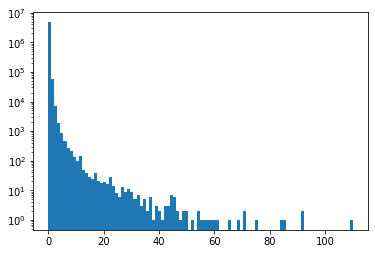

In [4]:
plt.hist(halos.iloc[:,5], bins=100)
plt.yscale('log')

In [5]:
halos

index  #scale(0)       id(1)  desc_scale(2)  desc_id(3)  \
1             51    1.00000  1122969403        0.00000          -1   
2             52    0.99057  1113370505        1.00000  1122969403   
3             53    0.97659  1103578712        0.99057  1113370505   
4             54    0.96738  1093866277        0.97659  1103578712   
5             55    0.95372  1084166184        0.96738  1093866277   
...          ...        ...         ...            ...         ...   
4884349  4884399    0.62557   754249688        0.63453   765435978   
4884350  4884400    0.61674   742999164        0.62557   754249688   
4884351  4884401    0.60804   731685427        0.61674   742999164   
4884352  4884402    0.59662   720303756        0.60804   731685427   
4884353  4884403    0.58820   708820372        0.59662   720303756   

         num_prog(4)  pid(5)  upid(6)  desc_pid(7)  phantom(8)  ...     A[z]  \
1                  1      -1       -1           -1           0  ... -0.59764   
2                  1      -1       -1           -1           0  ... -0.80679   
3                  1      -1       -1           -1           0  ...  0.82788   
4                  1      -1       -1           -1           0  ...  1.62453   
5                  1      -1       -1           -1           0  ...  1.72263   
...              ...     ...      ...          ...         ...  ...      ...   
4884349            1      -1       -1           -1           0  ...  2.13641   
4884350            1      -1       -1           -1           0  ...  1.74596   
4884351            1      -1       -1           -1           0  ...  1.19227   
4884352            1      -1       -1           -1           0  ...  0.48832   
4884353            0      -1       -1           -1           0  ... -0.29987   

         b_to_a(500c)  c_to_a(500c)  A[x](500c)  A[y](500c)  A[z](500c)  \
1             0.73477       0.30184     1.11307    -1.04583    -0.49679   
2             0.63215       0.15637     0.72804    -0.80641    -0.81522   
3             0.80679       0.18344    -0.68020     1.36609     1.06240   
4             0.19157       0.13979    -0.71347     0.31104     1.71859   
5             0.53219       0.33932    -0.44511     0.40864     1.70194   
...               ...           ...         ...         ...         ...   
4884349       0.75990       0.45814     0.80072     0.69614     2.14372   
4884350       0.55970       0.36708     1.11629     0.99403     1.74596   
4884351       0.47104       0.30776     1.14373     0.99976     1.19227   
4884352       0.58741       0.35526     0.65286     1.69596     0.35190   
4884353       0.56892       0.20679     0.31871     1.91386    -0.15039   

          T/|U|  M_pe_Behroozi  M_pe_Diemer  Halfmass_Radius  
1        0.6532    187100000.0   42000000.0            2.103  
2        0.8323    248100000.0   48000000.0            1.678  
3        0.7812    166800000.0   30000000.0            2.681  
4        0.9205    183100000.0   36000000.0            2.670  
5        0.5444    186600000.0   30000000.0            2.603  
...         ...            ...          ...              ...  
4884349  0.5525    154000000.0    6000000.0            3.489  
4884350  0.6376    177200000.0   30000000.0            2.730  
4884351  0.8559    201800000.0   48000000.0            1.864  
4884352  0.7588    205000000.0   42000000.0            2.343  
4884353  0.6768    168700000.0   30000000.0            2.532  

[4835849 rows x 50 columns]

In [6]:
zcut=2
mask=(1/halos['#scale(0)']-1)>zcut

In [7]:
zhalos=halos[mask]
acut_true=np.unique(zhalos['#scale(0)'])[-1]
zcut_true=1/acut_true-1

In [8]:
zhalos['desc_id(3)'][zhalos['#scale(0)']==acut_true]=-1

/tmp/ipykernel_2920/1104701273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zhalos['desc_id(3)'][zhalos['#scale(0)']==acut_true]=-1
/home/cj1223/.conda/envs/juptorch/lib/python3.9/site-packages/pandas/core/generic.py:8861: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


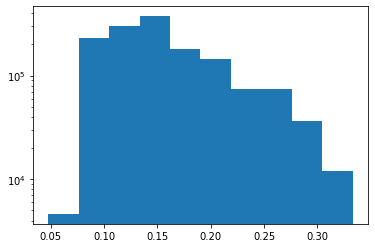

In [9]:
plt.hist(zhalos.iloc[:,np.where(load_cols==15)[0][0]+1])
plt.yscale('log')

In [10]:
# ## initial scaling
# hard=[0,2,15]
# def logit(x):
#     return np.log10((x+0.001)/(1.01-x))
# ##logit transform the hards
# for h in hard:
#     if h in tcol|s:
#         h1=np.where(load_cols==h)[0][0]+1
#         zhalos[zhalos.columns[h1]]=logit(zhalos[zhalos.columns[h1]])

log=[10,38, 39, 40, 41, 42]
#simple log for the rest
def logt(x):
    return np.log10(x+1)
for l in log:
    if l in tcols:
        l1=np.where(load_cols==l)[0][0]+1
        zhalos[zhalos.columns[l1]]=logt(zhalos[zhalos.columns[l1]])

scale_cols=np.array(tcols[~is_cat[tcols]])

/home/cj1223/.conda/envs/juptorch/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [11]:
zhalos.iloc[:,2:].describe()

id(1)  desc_scale(2)    desc_id(3)   num_prog(4)     pid(5)  \
count  1.436692e+06   1.436692e+06  1.436692e+06  1.436692e+06  1436692.0   
mean   2.039711e+08   2.246126e-01  2.012380e+08  9.576277e-01       -1.0   
std    1.069068e+08   7.153211e-02  1.108898e+08  4.304501e-01        0.0   
min    2.990000e+02   6.254000e-02 -1.000000e+00  0.000000e+00       -1.0   
25%    1.204642e+08   1.667800e-01  1.074520e+08  1.000000e+00       -1.0   
50%    2.090408e+08   2.226700e-01  2.090327e+08  1.000000e+00       -1.0   
75%    3.010882e+08   2.903400e-01  3.010968e+08  1.000000e+00       -1.0   
max    3.754532e+08   3.443400e-01  3.754532e+08  4.900000e+01       -1.0   

         upid(6)   desc_pid(7)    phantom(8)      Mvir(10)      Rvir(11)  ...  \
count  1436692.0  1.436692e+06  1.436692e+06  1.436692e+06  1.436692e+06  ...   
mean        -1.0  1.451597e+07  4.620058e-02  8.234622e+00  1.501331e+01  ...   
std          0.0  6.277794e+07  2.222217e-01  4.873326e-01  7.837837e+00  ...   
min         -1.0 -1.000000e+00  0.000000e+00  7.079181e+00  5.649000e+00  ...   
25%         -1.0 -1.000000e+00  0.000000e+00  7.924279e+00  1.095800e+01  ...   
50%         -1.0 -1.000000e+00  0.000000e+00  8.158362e+00  1.293400e+01  ...   
75%         -1.0 -1.000000e+00  0.000000e+00  8.468347e+00  1.650400e+01  ...   
max         -1.0  3.938207e+08  2.000000e+00  1.205423e+01  2.572930e+02  ...   

               A[z]  b_to_a(500c)  c_to_a(500c)    A[x](500c)    A[y](500c)  \
count  1.436692e+06  1.436692e+06  1.436692e+06  1.436692e+06  1.436692e+06   
mean   1.190446e+00  4.074095e-01  1.826698e-01  7.197134e-01  7.618509e-01   
std    2.305511e+00  2.945253e-01  2.018193e-01  1.641693e+00  1.653444e+00   
min   -1.525520e+01  0.000000e+00  0.000000e+00 -1.536240e+01 -8.886680e+00   
25%   -5.833400e-01  1.263700e-01  0.000000e+00 -1.802500e-01 -1.170300e-01   
50%    1.265115e+00  4.289400e-01  1.035400e-01  2.513800e-01  3.215100e-01   
75%    2.900135e+00  6.549900e-01  3.226900e-01  1.991950e+00  2.046980e+00   
max    2.791910e+01  9.995400e-01  9.791800e-01  2.271120e+01  2.024920e+01   

         A[z](500c)         T/|U|  M_pe_Behroozi   M_pe_Diemer  \
count  1.436692e+06  1.436692e+06   1.436692e+06  1.436692e+06   
mean   7.487315e-01  8.825302e-01   5.164784e+08  5.564257e+08   
std    1.641318e+00  6.865855e-01   5.468919e+09  6.501517e+09   
min   -1.399700e+01  0.000000e+00   1.006000e+07  0.000000e+00   
25%   -1.287100e-01  6.498000e-01   9.277500e+07  6.600000e+07   
50%    3.064000e-01  7.288000e-01   1.439384e+08  1.200000e+08   
75%    2.024250e+00  8.846000e-01   2.820000e+08  2.460000e+08   
max    1.997480e+01  4.782680e+01   1.055000e+12  1.048000e+12   

       Halfmass_Radius  
count     1.436692e+06  
mean      7.974807e+00  
std       3.728437e+00  
min       1.180000e-01  
25%       6.032000e+00  
50%       7.246000e+00  
75%       8.818000e+00  
max       1.191950e+02  

[8 rows x 48 columns]

In [12]:
scale_cols=np.array(tcols[~is_cat[tcols]])
indices = [i for i, x in enumerate(zhalos['desc_id(3)']) if x == -1]
print(f'Splitting to tree and scaling')
spli=np.split(np.array(zhalos)[:,1:], np.array(indices[1:]))
# del zhalos, halos
splits=[]
for s in spli:
    if s[0,np.where(load_cols==10)[0][0]]>10:
        splits.append(s)
splits=np.array(splits, dtype=object)
split=[]
for tree in splits:
    s=tree[np.logical_or(tree[:,3] == -1,tree[:,4]!=1)]
    for n in scale_cols:
        n1=np.where(load_cols==n)[0][0]
        s[:,n1]=scaler[n].transform(s[:,n1].reshape(-1,1)).reshape(np.shape(s[:,n1])) #this needs to change
    split.append(s)
split=np.array(split, dtype=object)
print('Split done')

Splitting to tree and scaling
Split done


In [13]:
a0=[]
for s in split:
    a0.append(s[0][0])
np.unique(a0) #!!!!! it works

array([1.98205501])

In [14]:
print('Loading targets')
ex=f'{i}_{j}_{k}/galprop_0-99.dat'
pdc=pd.read_table(target_path+ex, skiprows=0, delimiter=',', nrows=41, header=None)
newcols=pdc.iloc[:,0]
pds=pd.read_table(target_path+ex, skiprows=41, delimiter='\s+', header=None)
pds.columns=np.array(newcols)


Loading targets


In [15]:
zcut_SAM=np.unique(pds[pds.columns[3]])[np.isclose(np.unique(pds[pds.columns[3]]),zcut_true)][0]

In [16]:
pdz=pds[pds[pds.columns[3]]==zcut_SAM] # redshift

In [17]:
pdcen=pdz[(pdz[pds.columns[4]]==0)] ##central haloes

In [18]:
rhalid=np.array(pdcen[pds.columns[1]])
halwgal=[] ##scaled
ids=[]
out=[]
target=8
for idx, tree in enumerate(split): #split up into tree
    if tree[0,1] in rhalid:
        if len(tree)>20000:
            print(len(tree))
        else:
            halwgal.append(tree) ##scaled
            ids.append(idx)
            index=np.where(rhalid==tree[0,1])
            out.append(np.array(pdcen.iloc[index])[0][target]) ## target variable column


hraw=np.array(splits[ids], dtype=object) ##unscaled

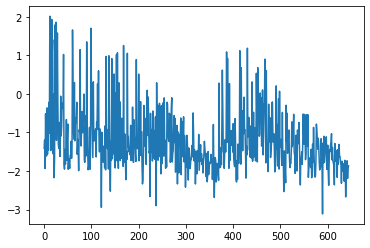

In [19]:
plt.plot(np.log10(out))

In [20]:
hals=[]
pr,de=[],[]
discards=[]
print('Making merger tree')
for n in tqdm(range(len(halwgal))):
    h=halwgal[n]
    roots=h[h[:,4]==0]
    mergers=h[h[:,4]>1]
    final=h[h[:,3]==-1]
    pro, des=[],[]
    discarded=[]
    for mid in mergers[:,1]:
        k=1
        descid=hraw[n][:,3][np.where(mid==hraw[n][:,1])] ##descendant ID of raw where the id of the merger is
        while descid not in mergers[:,1] and descid!=-1: 
            k+=1
            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]
        pro.append(mid)
        if descid!=-1:
            des.append(descid[0])
        else:
            des.append(hraw[n][:,3][np.where(mid==hraw[n][:,1])][0])
        discarded.append(1/k) 

    for r in roots:
        descid=hraw[n][:,3][np.where(r[1]==hraw[n][:,1])] 
        k=1
        while descid not in mergers[:,1] and descid!=[-1]: ##could add 1/k
            k+=1
            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]#consider adding the number of steps it went through
        pro.append(r[1])
        if descid!=-1:
            des.append(descid[0])
        else:
            des.append(hraw[n][:,3][np.where(r[1]==hraw[n][:,1])][0])
        discarded.append(1/k) 

    discards.append(np.array(discarded))
    des,pro=convert(des, pro)
    hal2=np.vstack([final,mergers,roots])
    # global mass_index
    if n==0:
        fcols=[i for i in range(len(hal2[0])) if not_include[i]==0] ##choose non-id cols to carry forward
        # mask=np.array([bool(i) for i in not_include])
        # idcols=load_cols[~mask] ##choose non-id cols to carry forward
        # mass_id=np.where(np.array(idcols)==10)[0][0]
    hal2=hal2[:,fcols] ##take away id's
    hals.append(hal2)
    pr.append([int(p) for p in pro])
    de.append([int(d) for d in des])
hals=np.array(hals,dtype=object)
out=np.log10(out) #homemade scaling

Making merger tree


100%|████████████████████████████████████████████████████████████████████| 645/645 [00:04<00:00, 152.48it/s]


Text(0.5, 1.0, '79.26201550387597')

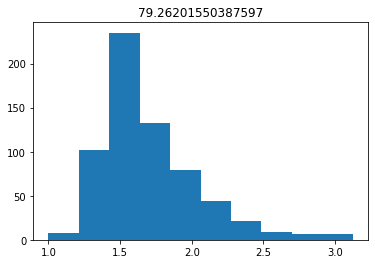

In [21]:
ls=[]
for h in hals:
    ls.append(len(h))
plt.hist(np.log10(ls))
plt.title(np.mean(ls))

In [22]:
dat=[]
for n in tqdm(range(len(out))):
    edge_index = torch.tensor([pr[n],de[n]], dtype=torch.long)
    x = torch.tensor(hals[n], dtype=torch.float)
    y=torch.tensor(out[n], dtype=torch.float)
    edge_attr=torch.tensor(discards[n], dtype=torch.float)
    graph=Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    dat.append(graph)
stop=time.time()
print(f'Done with tree. \n Time elapsed {stop-start} s')

100%|██████████████████████████████████████████████████████████████████| 645/645 [00:00<00:00, 20620.96it/s]

Done with tree. 
 Time elapsed 78.06101155281067 s


In [23]:
case=f'test_z{zcut_true:.1f}_smass'
save=1
if save:
    print("Saving dataset")
    if not osp.exists(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}'):
        os.mkdir(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}')

    with open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'wb') as handle:
        pickle.dump(dat, handle)

Saving dataset
